In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import pyfolio as pf
import datetime
import os
import sys
from scipy.optimize import minimize
%matplotlib inline

In [3]:
sys.path.append('../src/factorinv/')

In [4]:
import analysis
import utils

# 读入数据

In [5]:
codes = utils.get_index_component('000300.SH')

In [6]:
pnl = utils.get_factor_panel(codes, columns='A,D,G,H,I,J')

In [7]:
pnl

<class 'pandas.core.panel.Panel'>
Dimensions: 300 (items) x 1530 (major_axis) x 5 (minor_axis)
Items axis: 000001.SZ to 603993.SH
Major_axis axis: 2011-04-01 00:00:00.005000 to 2017-07-17 00:00:00.005000
Minor_axis axis: pe to roic

In [8]:
pnl.ix[:, :, 'return'] = pnl.minor_xs('close').pct_change()

In [9]:
dic = {}

# carry因子

In [10]:
df = pnl.minor_xs('roic')

In [11]:
weight_df = analysis.factor_weight(df, ascending=False, frequency='M')

In [12]:
weight_df = weight_df.div(weight_df.sum(axis=1), axis='index')

In [13]:
daily_return = analysis.calculate_return(weight_df, pnl.minor_xs('return'))

In [14]:
daily_return = daily_return[daily_return != 0]

In [15]:
dic['carry'] = daily_return

In [16]:
utils.get_metrics(daily_return)

Annual return: 37.82%
Sharpe ratio: 1.30
Annual volatility: 27.70%
Max drawdown: -38.69%


In [17]:
acc_ret = utils.get_accumulated_return(daily_return)

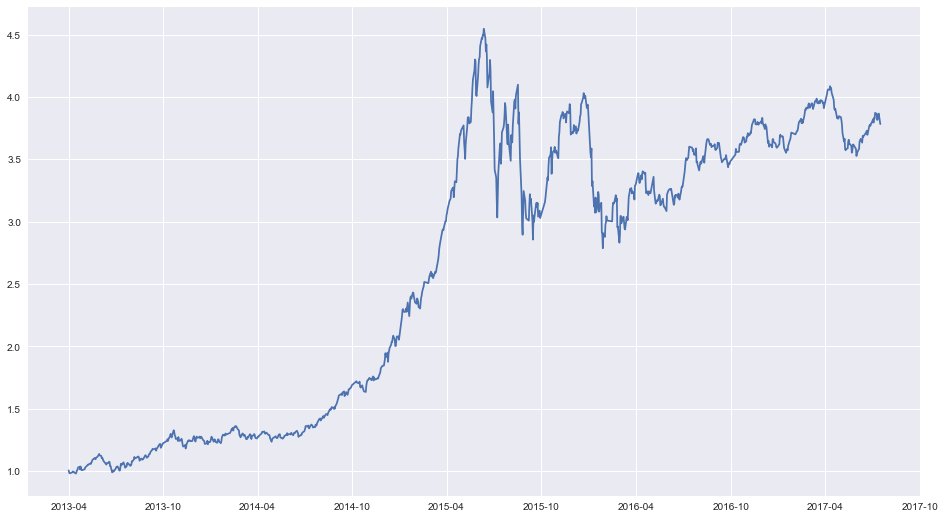

In [18]:
plt.figure(figsize=(16, 9))
plt.plot(acc_ret)

# 价值因子

In [19]:
df = pnl.minor_xs('pe')

In [20]:
weight_df = analysis.factor_weight(df, ascending=True, frequency='M')

In [21]:
weight_df = weight_df.div(weight_df.sum(axis=1), axis='index')

In [22]:
daily_return = analysis.calculate_return(weight_df, pnl.minor_xs('return'))

In [23]:
daily_return = daily_return[daily_return != 0]

In [24]:
dic['value'] = daily_return

In [25]:
utils.get_metrics(daily_return)

Annual return: 31.49%
Sharpe ratio: 1.13
Annual volatility: 27.62%
Max drawdown: -38.19%


In [26]:
acc_ret = utils.get_accumulated_return(daily_return)

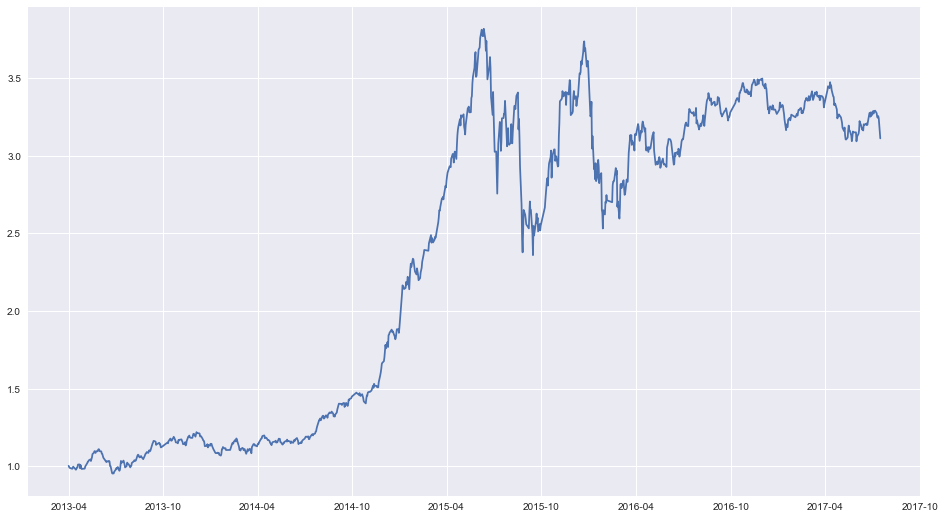

In [27]:
plt.figure(figsize=(16, 9))
plt.plot(acc_ret)

# 动量因子

In [28]:
pnl.ix[:, :, 'momentum'] = pnl.minor_xs('return').rolling(window=121).mean()

In [29]:
df = pnl.minor_xs('momentum')

In [30]:
weight_df = analysis.factor_weight(df, ascending=False, frequency='M')
weight_df = weight_df.div(weight_df.sum(axis=1), axis='index')
daily_return = analysis.calculate_return(weight_df, pnl.minor_xs('return'))

In [31]:
daily_return = daily_return[daily_return != 0]

In [32]:
dic['momentum'] = daily_return

In [33]:
utils.get_metrics(daily_return)

Annual return: 19.19%
Sharpe ratio: 0.73
Annual volatility: 30.31%
Max drawdown: -50.43%


In [34]:
acc_ret = utils.get_accumulated_return(daily_return)

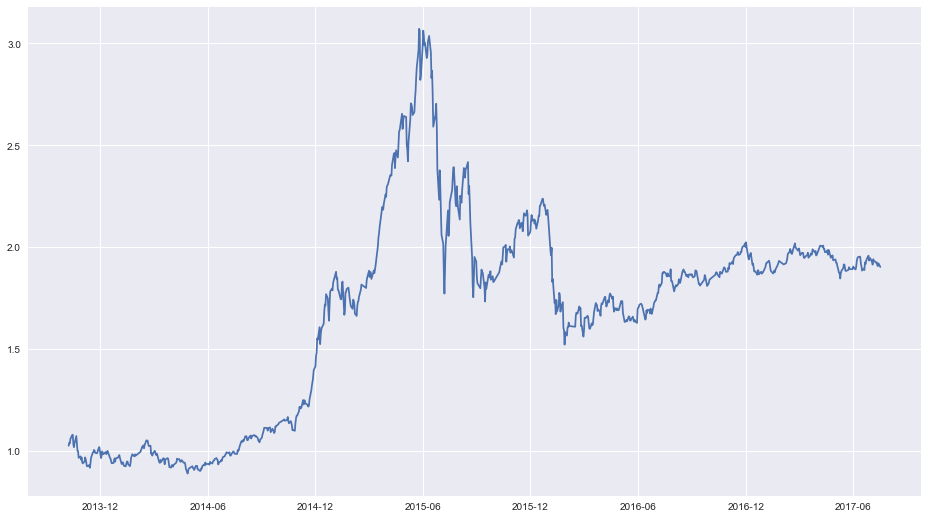

In [35]:
plt.figure(figsize=(16, 9))
plt.plot(acc_ret)

# 波动率因子

In [36]:
pnl.ix[:, :, 'volatility'] = pnl.minor_xs('return').rolling(window=60).std()

In [37]:
df = pnl.minor_xs('volatility')

In [38]:
weight_df = analysis.factor_weight(df, ascending=True, frequency='M')
weight_df = weight_df.div(weight_df.sum(axis=1), axis='index')
daily_return = analysis.calculate_return(weight_df, pnl.minor_xs('return'))

In [39]:
daily_return = daily_return[daily_return != 0]

In [40]:
dic['volatility'] = daily_return

In [41]:
utils.get_metrics(daily_return)

Annual return: 43.42%
Sharpe ratio: 1.76
Annual volatility: 21.87%
Max drawdown: -35.94%


In [42]:
acc_ret = utils.get_accumulated_return(daily_return)

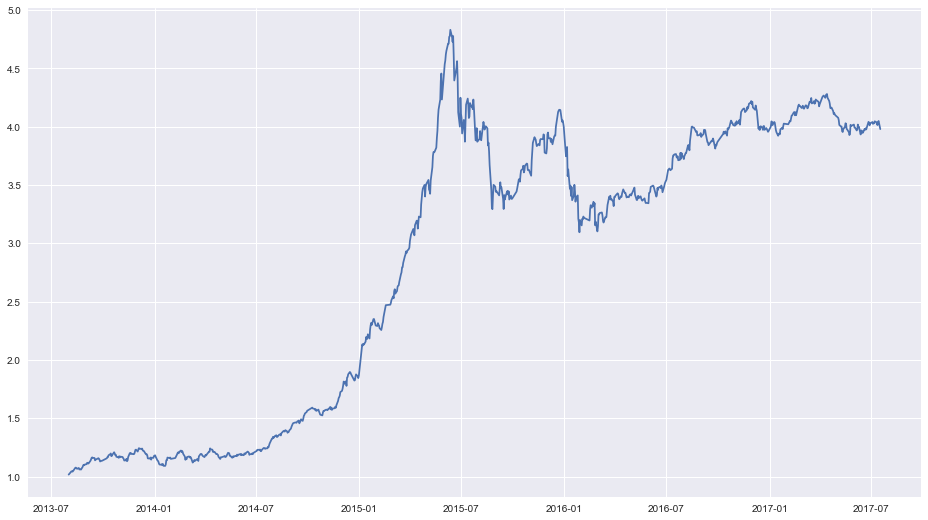

In [43]:
plt.figure(figsize=(16, 9))
plt.plot(acc_ret)

# 持仓盈利因子

In [44]:
df = pnl.minor_xs('profit percentage')

In [45]:
weight_df = analysis.factor_weight(df, ascending=True, frequency='M')

In [46]:
weight_df = weight_df.div(weight_df.sum(axis=1), axis='index')

In [47]:
daily_return = analysis.calculate_return(weight_df, pnl.minor_xs('return'))

In [48]:
daily_return = daily_return[daily_return != 0]

In [49]:
dic['profit'] = daily_return

In [50]:
utils.get_metrics(daily_return)

Annual return: 16.90%
Sharpe ratio: 0.70
Annual volatility: 28.20%
Max drawdown: -48.19%


In [51]:
acc_ret = utils.get_accumulated_return(daily_return)

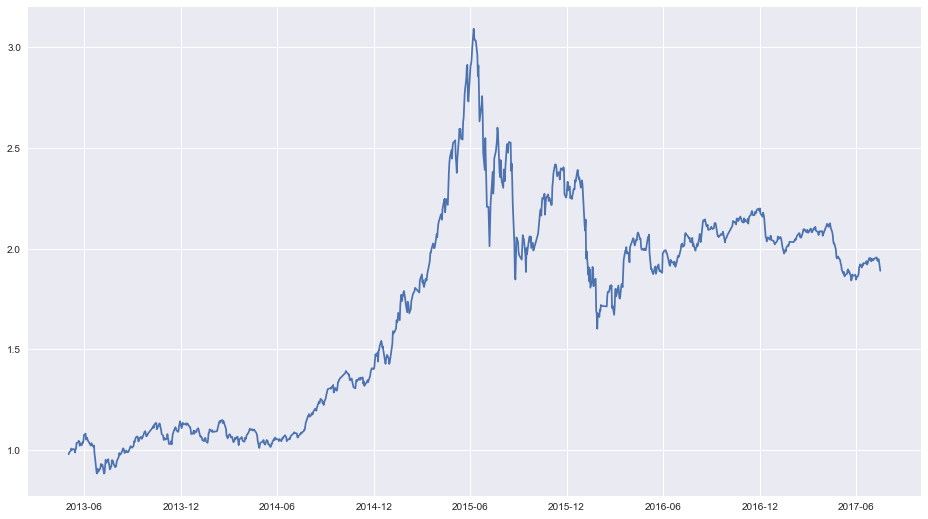

In [52]:
plt.figure(figsize=(16, 9))
plt.plot(acc_ret)

In [53]:
df = pd.DataFrame(dic)

In [54]:
df[df.index >= '2016-03-01'].corr()

,carry,momentum,profit,value,volatility
carry,1.000000,0.854625,0.926765,0.934186,0.863945
momentum,0.854625,1.000000,0.811161,0.829084,0.814463
profit,0.926765,0.811161,1.000000,0.941983,0.863670
value,0.934186,0.829084,0.941983,1.000000,0.882950
volatility,0.863945,0.814463,0.863670,0.882950,1.000000


# 综合以上因子

In [55]:
weight_df = analysis.factor_weight(pnl.minor_xs('pe'), ascending=True, threshold=0.05, frequency='M')

In [57]:
temp_df = analysis.factor_weight(pnl.minor_xs('roic'), ascending=False, threshold=0.05, frequency='M')
weight_df += temp_df

In [58]:
temp_df = analysis.factor_weight(pnl.minor_xs('momentum'), ascending=False, threshold=0.05, frequency='M')
weight_df += temp_df

In [59]:
temp_df = analysis.factor_weight(pnl.minor_xs('volatility'), ascending=True, threshold=0.05, frequency='M')
weight_df += temp_df

In [60]:
temp_df = analysis.factor_weight(pnl.minor_xs('profit percentage'), ascending=True, threshold=0.05, frequency='M')
weight_df += temp_df

In [61]:
weight_df.sum(axis=1).tail()

2017-07-11 00:00:00.005    64.0
2017-07-12 00:00:00.005    64.0
2017-07-13 00:00:00.005    64.0
2017-07-14 00:00:00.005    64.0
2017-07-17 00:00:00.005    72.0
dtype: float64

In [62]:
weight_df = weight_df.div(weight_df.sum(axis=1), axis='index')

In [63]:
daily_return = analysis.calculate_return(weight_df, pnl.minor_xs('return'))

In [64]:
daily_return = daily_return[daily_return != 0]

In [65]:
utils.get_metrics(daily_return)

Annual return: 24.90%
Sharpe ratio: 1.02
Annual volatility: 24.92%
Max drawdown: -46.58%


In [66]:
acc_ret = utils.get_accumulated_return(daily_return)

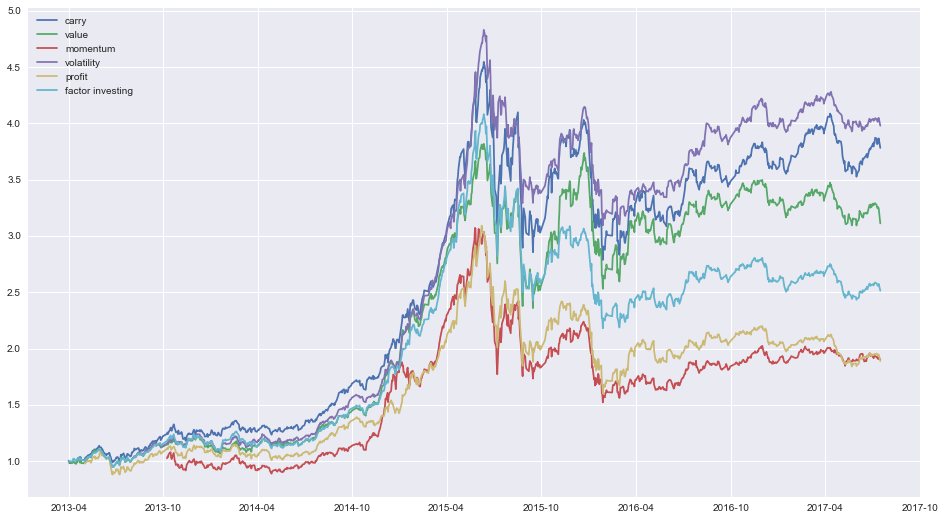

In [67]:
plt.figure(figsize=(16, 9))
plt.plot((1+dic['carry']).cumprod(), label='carry')
plt.plot((1+dic['value']).cumprod(), label='value')
plt.plot((1+dic['momentum']).cumprod(), label='momentum')
plt.plot((1+dic['volatility']).cumprod(), label='volatility')
plt.plot((1+dic['profit']).cumprod(), label='profit')
plt.plot(acc_ret, label='factor investing')
plt.legend()

# 过去代码

In [25]:
ret_df = pnl.minor_xs('ret')

In [26]:
ret_df.tail()

,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,603987.SH,603988.SH,603989.SH,603990.SH,603991.SH,603993.SH,603996.SH,603997.SH,603998.SH,603999.SH
2017-05-31 00:00:00.005,0.010989,0.034550,0.0,0.003861,-0.008274,0.0,-0.008392,0.004098,0.014257,0.003361,...,-0.006678,-0.011971,0.006194,0.064865,0.011432,-0.004728,-0.016166,-0.018455,0.000000,-0.005079
2017-06-01 00:00:00.005,-0.001087,-0.007996,0.0,-0.023077,-0.021454,0.0,-0.012694,-0.012245,-0.054217,-0.008375,...,-0.072269,-0.031987,-0.012580,-0.072081,-0.076964,-0.033254,0.016432,0.000000,-0.021821,-0.045431
2017-06-02 00:00:00.005,-0.002176,-0.006638,0.0,0.005906,0.031669,0.0,0.015714,0.009642,0.050955,0.075450,...,0.042120,-0.004172,-0.014367,0.021335,0.029446,-0.007371,-0.005774,0.000000,0.021538,0.016043
2017-06-05 00:00:00.005,-0.015267,0.007160,0.0,0.000000,0.001181,0.0,0.001406,0.008186,-0.014141,-0.003665,...,0.015645,0.005195,0.000825,0.004821,0.067686,0.007426,-0.006969,0.000000,0.038404,0.018421
2017-06-06 00:00:00.005,0.001107,-0.010900,0.0,0.005871,0.005896,0.0,0.002809,0.005413,0.008197,0.018917,...,0.013693,-0.004668,0.000000,0.000267,0.026790,0.004914,0.005848,0.000000,0.000000,0.001550


In [161]:
def factor_return(ret_df, df, ascending=True, percent=0.1):
    '''
    计算因子收益率
    ret_df: 收益率矩阵
    df: 因子矩阵
    ascending: 因子从小到大
    percent: 取前百分比
    '''
    assert(ret_df.shape == df.shape)
    # 因子排序
    rdf = df.rank(axis=1, ascending=ascending, pct=True, method='first')
    rdf = rdf[rdf <= percent]
    factor_df = pd.Series(index=ret_df.index)
    for index in rdf.index:
        rank, ret = rdf.loc[index], ret_df.loc[index]
        # 取包含该因子的股票
        stocks = rank[~rank.isnull()].index
        # 计算股票集的平均收益率
#         print stocks
        factor_ret = ret[stocks].mean()
        factor_df.loc[index] = factor_ret
    return factor_df

# 市值因子（小市值）

In [111]:
df = pnl.minor_xs('caps')

In [112]:
factor_df = factor_return(ret_df, df)

In [113]:
cum_ret = (1 + factor_df).cumprod()

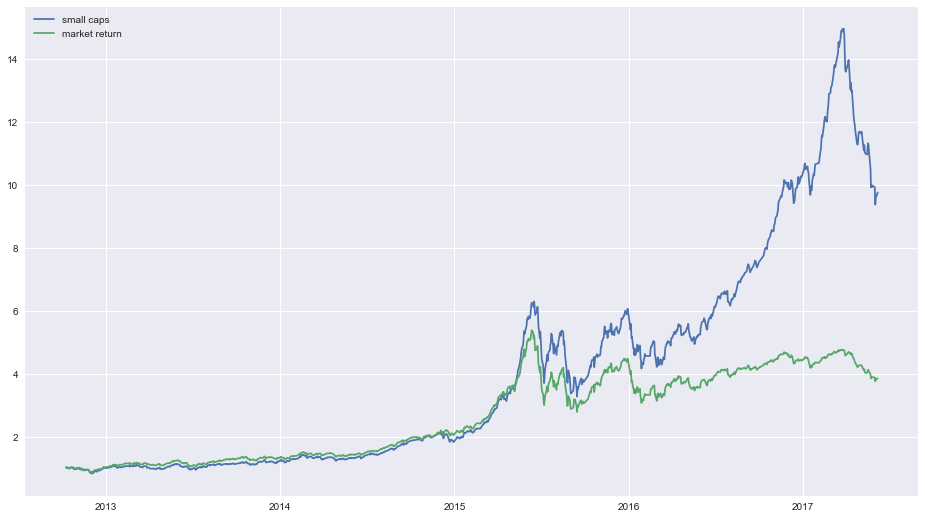

In [114]:
plt.figure(figsize=(16, 9))
plt.plot(cum_ret, label='small caps')
plt.plot((1+ret_df.mean(axis=1)).cumprod(), label='market return')
plt.legend()

# 市值因子（大市值）

In [115]:
df = pnl.minor_xs('caps')

In [116]:
factor_df = factor_return(ret_df, df, ascending=False, percent=0.01)

In [117]:
cum_ret = (1 + factor_df).cumprod()

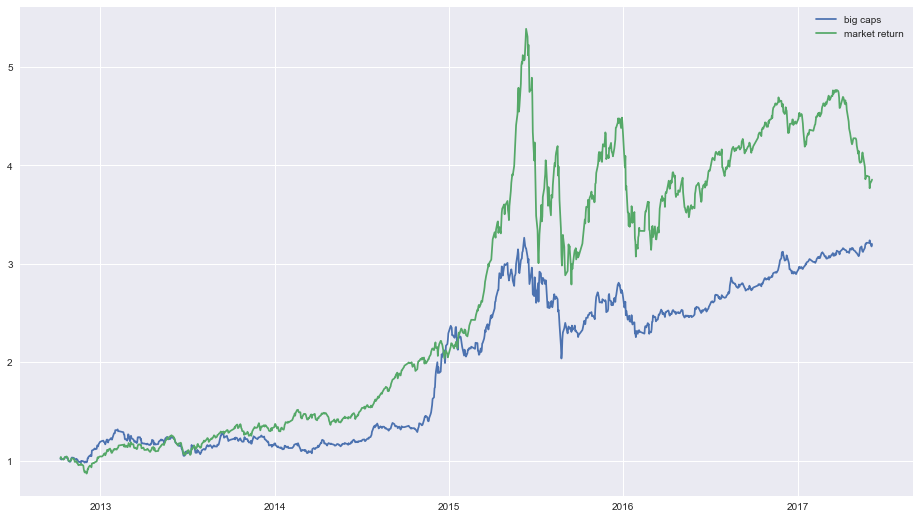

In [119]:
plt.figure(figsize=(16, 9))
plt.plot(cum_ret, label=u'big caps')
plt.plot((1+ret_df.mean(axis=1)).cumprod(), label='market return')
plt.legend()

# 波动率因子（一个月低波动率）

In [175]:
df = pnl.minor_xs('volatility 1M')

In [176]:
factor_df = factor_return(ret_df, df, percent=0.1)

In [177]:
cum_ret = (1 + factor_df).cumprod()

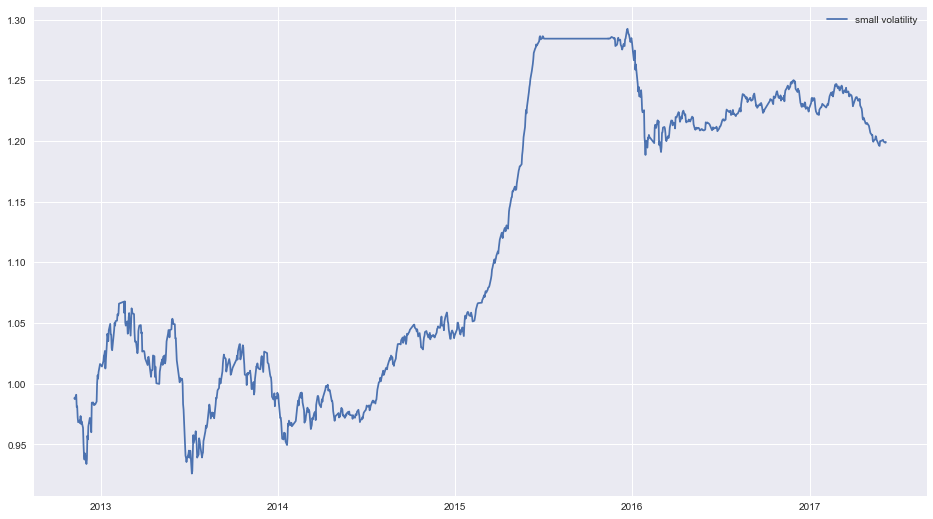

In [178]:
plt.figure(figsize=(16, 9))
plt.plot(cum_ret, label=u'small volatility')
# plt.plot((1+ret_df.mean(axis=1)).cumprod(), label='market return')
plt.legend()